In [0]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

In [17]:
data = pd.read_csv("./Data/BreastCancer/data.csv")
data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [18]:
# #Show all rows containt Null values
data.iloc[data.index[(data.T == np.nan).sum() > 1]]
# show statistics
# data.count() 

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32


In [0]:
# Get labels and features

# Encoding labels
labels_raw = np.asarray(data.iloc[:, 1])
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels_raw)

# Feature Normalization
features = np.asarray(data.iloc[:, 2:-1])

In [20]:
# Random split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)

# Stratified Split to Train/Validation and Test Dataset
def split_data(X, y, n_splits=4):
  skf = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
  skf.get_n_splits(X, y)
  for train_index, test_index in (skf.split(X, y)):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    break
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(features, labels)

TRAIN: (426,) TEST: (143,)


Best params:  {'kneighbors__n_neighbors': 11, 'pca__n_components': 5}
Best Training Score 0.9624413145539906
Test Score 0.986013986013986


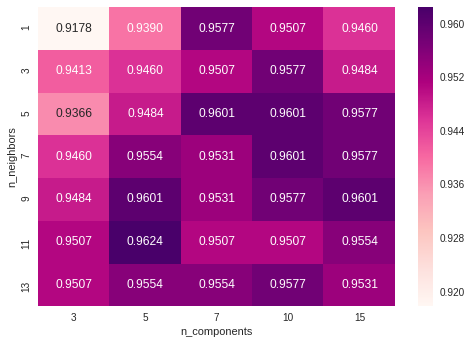

In [21]:
# K Nearest Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
# allow data processing similar in both validation process and test process
pipe = Pipeline([("scaler", preprocessing.StandardScaler()), ("pca", PCA()), ("kneighbors", KNeighborsClassifier())])
param_grid = {"kneighbors__n_neighbors": np.arange(1, 15, 2, dtype=np.int32), "pca__n_components": [3, 5, 7, 10, 15]}
gs = model_selection.GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

# Train set
gs.fit(X_train, y_train)
results = gs.cv_results_["mean_test_score"].reshape(7,5)
ax = sns.heatmap(results, annot=True, fmt=".4f", xticklabels=param_grid["pca__n_components"], yticklabels=param_grid["kneighbors__n_neighbors"], cmap="RdPu")
ax.set_xlabel("n_components")
ax.set_ylabel("n_neighbors")

print("Best params: ", gs.best_params_)
print("Best Training Score", gs.best_score_)

# Test set
print("Test Score", gs.score(X_test, y_test))

Best params: {'svm__C': 3, 'svm__gamma': 0.03, 'svm__kernel': 'rbf'}
Best Training Score 0.971830985915493
Test Score 0.986013986013986


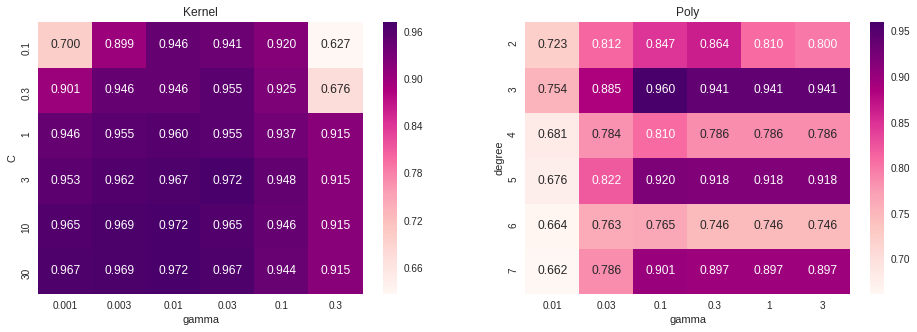

In [22]:
# SVM Kernel/ Poly Models
from sklearn.svm import SVC
pipe = Pipeline([("scaler", preprocessing.StandardScaler()), ("svm", SVC())])
param_grid = [{'svm__kernel': ['rbf'], 'svm__C': [0.1, 0.3, 1, 3, 10, 30], 'svm__gamma': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]},
             {'svm__kernel': ['poly'], 'svm__degree': [2, 3, 4, 5, 6, 7], 'svm__gamma': [0.01, 0.03, 0.1, 0.3, 1, 3]}]
gs = model_selection.GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

# Train set
gs.fit(X_train, y_train)

# Draw heatmap
results = gs.cv_results_["mean_test_score"].reshape(2, 6, 6)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1 = sns.heatmap(results[0], annot=True, fmt=".3f", xticklabels=param_grid[0]["svm__gamma"], yticklabels=param_grid[0]["svm__C"], cmap="RdPu", ax=ax1)
ax1.set_title("Kernel")
ax1.set_xlabel("gamma")
ax1.set_ylabel("C")

ax2 = sns.heatmap(results[1], annot=True, fmt=".3f", xticklabels=param_grid[1]["svm__gamma"], yticklabels=param_grid[1]["svm__degree"], cmap="RdPu", ax=ax2)
ax2.set_title("Poly")
ax2.set_xlabel("gamma")
ax2.set_ylabel("degree")

print("Best params:", gs.best_params_)
print("Best Training Score", gs.best_score_)

# Test set
print("Test Score", gs.score(X_test, y_test))

Best params:  {'forest__max_depth': 9, 'forest__n_estimators': 35}
Best Training Score 0.9671361502347418
Test Score 0.9440559440559441


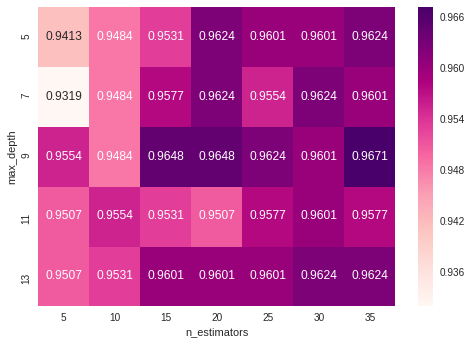

In [23]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# allow data processing similar in both validation process and test process
pipe = Pipeline([("scaler", preprocessing.StandardScaler()), ("forest", RandomForestClassifier())])
param_grid = {"forest__n_estimators": np.arange(5, 40, 5), "forest__max_depth": np.arange(5, 15, 2)}
gs = model_selection.GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

# Train set
gs.fit(X_train, y_train)
results = gs.cv_results_["mean_test_score"].reshape(5,7)
ax = sns.heatmap(results, annot=True, fmt=".4f", xticklabels=param_grid["forest__n_estimators"], yticklabels=param_grid["forest__max_depth"], cmap="RdPu")
ax.set_xlabel("n_estimators")
ax.set_ylabel("max_depth")

print("Best params: ", gs.best_params_)
print("Best Training Score", gs.best_score_)

# Test set
print("Test Score", gs.score(X_test, y_test))

## Deep Learning


In [24]:
# Import library
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Tensorboard setup
from keras.callbacks import TensorBoard
import os

# Change directory to the notebook directory
os.chdir('/content/drive/Colab Notebooks')
import tboard

# Set up folder to log file
ROOT = "/tmp"
LOG_DIR = os.path.join(ROOT, 'log/')

# training and validation data
X_set, X_test, y_set, y_test = train_test_split(features, labels, test_size=0.3)
# X_set, X_test, y_set, y_test = split_data(features, labels)
X_train, X_val, y_train, y_val = split_data(X_set, y_set, n_splits=5)

# Processing train and val
scl = preprocessing.StandardScaler()
X_train = scl.fit_transform(X_train)
X_val = scl.transform(X_val)

# Hyperparams
n_epoches = 100
batch_size = 50

# Build model
model = Sequential([
    Dense(50, activation='relu', input_shape=(30,)),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Tensorboard
callback = TensorBoard(LOG_DIR)
callback.set_model(model)

# Run model
for i in range(n_epoches):
  for batch_index in range(0, int(len(X_train)/batch_size) + 1):
    batch = range(batch_index*batch_size, min(len(X_train), (batch_index+1)*batch_size))
    loss = model.train_on_batch(X_train[batch], y_train[batch])
  val_loss, val_acc = model.test_on_batch(X_val, y_val)
  print("Epoches %d val acc %.3f" % (i, val_acc))
  
  summary = tf.Summary(value=[
      tf.Summary.Value(tag="loss", simple_value=val_loss),
      tf.Summary.Value(tag="accuracy", simple_value=val_acc)
  ])
  callback.writer.add_summary(summary, i)
  callback.writer.flush()

# Processing train/val and test
scl1 = preprocessing.StandardScaler()
X_set = scl1.fit_transform(X_set)
X_test = scl1.transform(X_test)

test_loss, test_acc = model.test_on_batch(X_test, y_test)
print("test acc", test_acc)

tboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )

TRAIN: (298,) TEST: (100,)
Epoches 0 val acc 0.420
Epoches 1 val acc 0.630
Epoches 2 val acc 0.870
Epoches 3 val acc 0.940
Epoches 4 val acc 0.940
Epoches 5 val acc 0.940
Epoches 6 val acc 0.950
Epoches 7 val acc 0.940
Epoches 8 val acc 0.950
Epoches 9 val acc 0.960
Epoches 10 val acc 0.970
Epoches 11 val acc 0.970
Epoches 12 val acc 0.970
Epoches 13 val acc 0.970
Epoches 14 val acc 0.980
Epoches 15 val acc 0.980
Epoches 16 val acc 0.980
Epoches 17 val acc 0.980
Epoches 18 val acc 0.980
Epoches 19 val acc 0.980
Epoches 20 val acc 0.980
Epoches 21 val acc 0.980
Epoches 22 val acc 0.980
Epoches 23 val acc 0.980
Epoches 24 val acc 0.980
Epoches 25 val acc 0.980
Epoches 26 val acc 0.980
Epoches 27 val acc 0.980
Epoches 28 val acc 0.980
Epoches 29 val acc 0.980
Epoches 30 val acc 0.980
Epoches 31 val acc 0.980
Epoches 32 val acc 0.980
Epoches 33 val acc 0.980
Epoches 34 val acc 0.980
Epoches 35 val acc 0.980
Epoches 36 val acc 0.980
Epoches 37 val acc 0.980
Epoches 38 val acc 0.980
Epoches 

'http://e443b270.ngrok.io'